<a href="https://colab.research.google.com/github/marjph/Stat-226/blob/master/Pokemon_PCA_and_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import MeanShift
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [0]:
data = pd.read_csv("Pokemondb.csv")

In [23]:
data

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,719,Diancie,Rock,Fairy,600,50,100,150,100,150,50,6,True
796,719,DiancieMega Diancie,Rock,Fairy,700,50,160,110,160,110,110,6,True
797,720,HoopaHoopa Confined,Psychic,Ghost,600,80,110,60,150,130,70,6,True
798,720,HoopaHoopa Unbound,Psychic,Dark,680,80,160,60,170,130,80,6,True


In [24]:
!pip install pandas_profiling

In [0]:
import pandas_profiling as pp

In [26]:
report = pp.ProfileReport(data)

/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [27]:
report

Number of variables,13
Number of observations,800
Total Missing (%),3.7%
Total size in memory,75.9 KiB
Average record size in memory,97.2 B
Numeric,8
Categorical,2
Boolean,1
Date,0
Text (Unique),1
Rejected,1


In [28]:
data.shape

(800, 13)

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
#             800 non-null int64
Name          800 non-null object
Type 1        800 non-null object
Type 2        414 non-null object
Total         800 non-null int64
HP            800 non-null int64
Attack        800 non-null int64
Defense       800 non-null int64
Sp. Atk       800 non-null int64
Sp. Def       800 non-null int64
Speed         800 non-null int64
Generation    800 non-null int64
Legendary     800 non-null bool
dtypes: bool(1), int64(9), object(3)
memory usage: 75.9+ KB


In [30]:
data.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


In [31]:
data.loc[data['Name'].isnull()==True]

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary


In [0]:
data['Name'] = data['Name'].fillna('Primeape')
data['Type 2'] = data['Type 2'].fillna('None')

In [0]:
data["Total"] = data["HP"] + data["Attack"] + data["Defense"] + data["Sp. Atk"] + data["Sp. Def"] + data["Speed"]
stats=['Attack', 'Defense','HP', 'Sp. Atk','Sp. Def', 'Speed', 'Total']

<function pandas.plotting._misc.scatter_matrix>

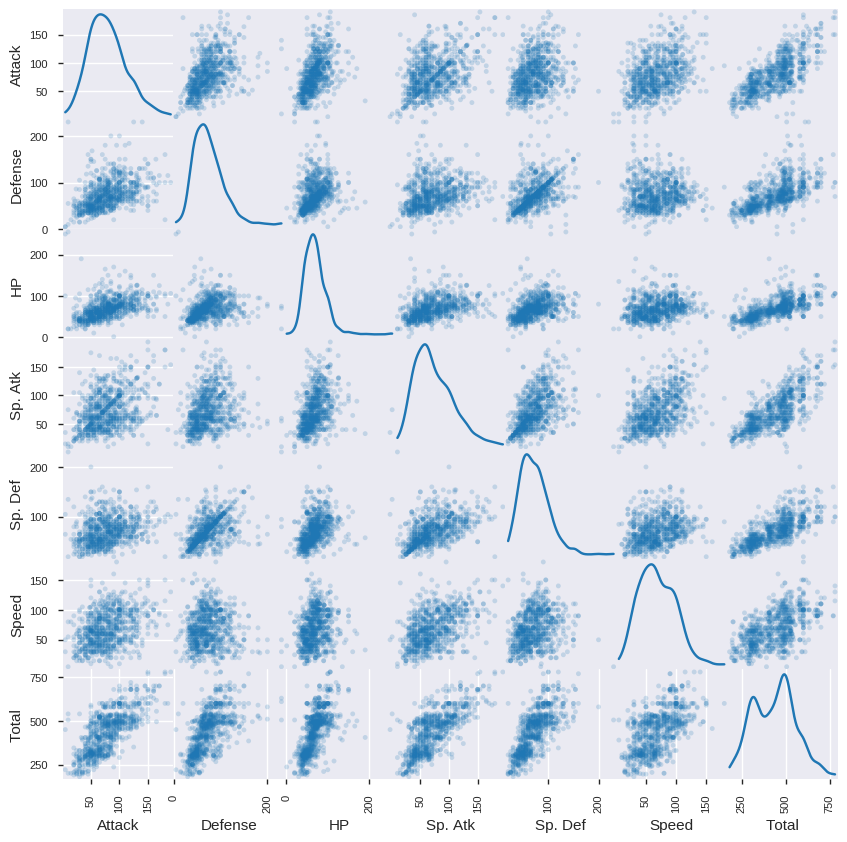

In [34]:
from pandas.plotting import scatter_matrix
scatter_matrix(data[stats], alpha=0.2, figsize=(10, 10), diagonal='kde')
scatter_matrix

In [36]:
#standardize the data
stat = ['HP', 'Attack', 'Defense', 'Sp. Atk','Sp. Def', 'Speed']
poke_stat_scaled = StandardScaler().fit_transform(data[stat])

print("mean: "+str(poke_stat_scaled[:,0].mean()))  # very close to 0
print("SD: "+str(poke_stat_scaled[:,0].std()))  # very close to 1

mean: -2.486899575160351e-16
SD: 1.0


# PERFORM PCA

In [37]:
pca = PCA(n_components = 'mle',svd_solver='full') #maximum likelihood estimation
pcscores = pd.DataFrame(pca.fit_transform(poke_stat_scaled)) 
pcscores.columns = ['PC'+str(i+1) for i in range(len(pcscores.columns))]
#print(pca.explained_variance_ratio_)
#print(pca.explained_variance_)

print("Number of principle components: "+str(pca.n_components_))
pcaVarRatioSum = 0
for i in range(pca.n_components_):
    pcaVarRatio = pca.explained_variance_ratio_.tolist()
    pcaSingleVarRatio = "{:.2%}".format(pcaVarRatio[i])
    print("PC"+str(i+1)+": "+str(pcaSingleVarRatio))
    pcaVarRatioSum = pcaVarRatioSum + pcaVarRatio[i]
print("Total explained variance ratio: "+"{:.2%}".format(pcaVarRatioSum))

Number of principle components: 5
PC1: 45.19%
PC2: 18.23%
PC3: 12.98%
PC4: 12.01%
PC5: 7.14%
Total explained variance ratio: 95.55%


In [38]:
#loading factors
loadings = pd.DataFrame(pca.components_, columns=stat)
loadings.index = ['PC'+str(i+1) for i in range(len(pcscores.columns))]
loadings

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
PC1,0.389886,0.439254,0.363747,0.457162,0.448570,0.335440
PC2,0.084835,-0.011825,0.628789,-0.305414,0.239097,-0.668463
PC3,-0.471926,-0.594153,0.069339,0.305612,0.565594,0.078513
PC4,0.717691,-0.405836,-0.419237,0.147517,0.185445,-0.297163
PC5,0.219991,-0.190255,0.059032,-0.735345,0.300200,0.530161


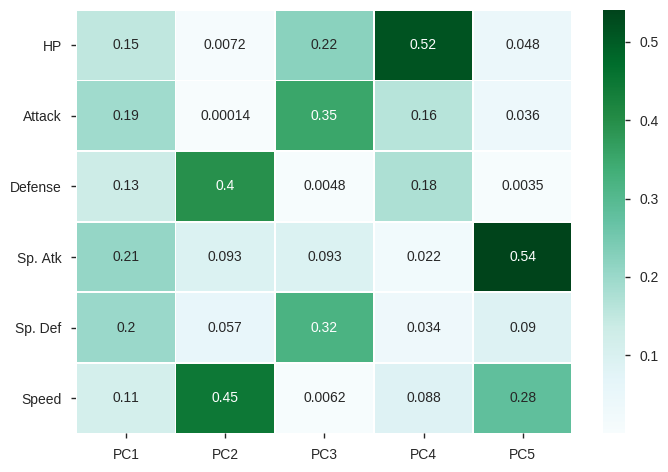

In [39]:
#visualize the square values of loading factors
load_sqr = loadings**2 #so that the sum of the stats will equal to 1
ax1 = sns.heatmap(load_sqr.transpose(), linewidths=0.5, cmap="BuGn", annot=True)
ax1.set_xticklabels(ax1.xaxis.get_majorticklabels(), rotation=0)
ax1.set_yticklabels(ax1.yaxis.get_majorticklabels(), rotation=0)
plt.show()

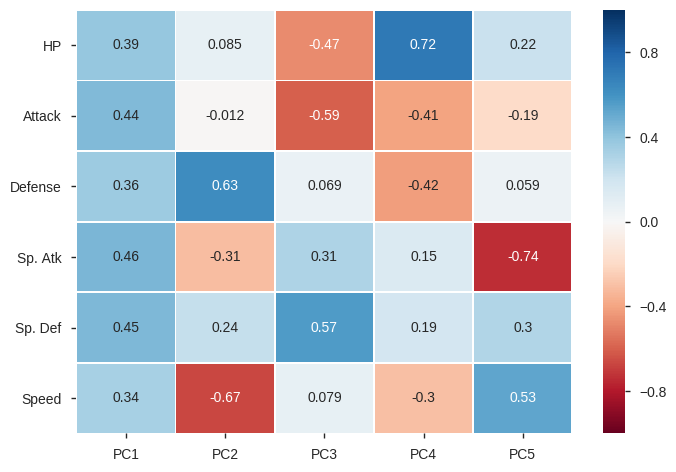

In [40]:
ax = sns.heatmap(loadings.transpose(), center=0, linewidths=0.5, 
                 cmap="RdBu", vmin=-1, vmax=1, annot=True)
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=0)
ax.set_yticklabels(ax.yaxis.get_majorticklabels(), rotation=0)
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


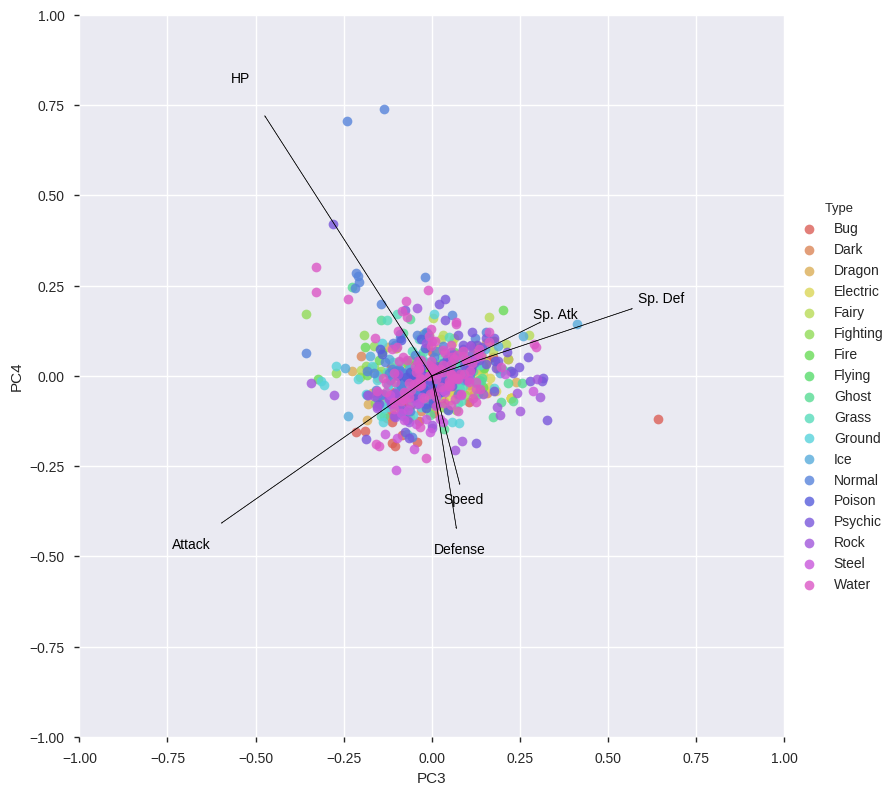

In [41]:
from math import sqrt
# Create labels abased on Type 1
labels = set(data['Type 1'])
data['type'] = data['Type 1']
lab_dict = dict()
for i, elem in enumerate(labels):
    lab_dict[elem] = i
data = data.replace({'type' : lab_dict})

pc_types = pcscores.copy()
pc_types['Type'] = data['Type 1']
pc_types = pc_types.sort_values('Type')

# Biplots
def biplot(pcscores, loadings, xval=0, yval=1, max_arrow=0.2, alpha=0.4):
    n = loadings.shape[1]
    scalex = 1.0 / (pcscores.iloc[:, xval].max() - pcscores.iloc[:, xval].min())  # Rescaling to be from -1 to +1
    scaley = 1.0 / (pcscores.iloc[:, yval].max() - pcscores.iloc[:, yval].min())

    pcscores.iloc[:, xval] = pcscores.iloc[:, xval] * scalex
    pcscores.iloc[:, yval] = pcscores.iloc[:, yval] * scaley

    g = sns.lmplot(x='PC{}'.format(xval + 1), y='PC{}'.format(yval + 1), hue='Type', data=pcscores,
                   fit_reg=False, size=8, palette=sns.color_palette("hls", n_colors=20))

    for i in range(n):
        # Only plot the longer ones
        length = sqrt(loadings.iloc[xval, i] ** 2 + loadings.iloc[yval, i] ** 2)
        if length < max_arrow:
            continue

        plt.arrow(0, 0, loadings.iloc[xval, i], loadings.iloc[yval, i], color='k', alpha=0.9)
        plt.text(loadings.iloc[xval, i] * 1.15, loadings.iloc[yval, i] * 1.15,
                 loadings.columns.tolist()[i], color='k', ha='center', va='center')
        
    g.set(ylim=(-1, 1))
    g.set(xlim=(-1, 1))   
    plt.grid(True)
    
# Actually make a biplot (PC3 vs PC4)
biplot(pc_types, loadings, 2, 3, max_arrow=0.3)

In [42]:
pcscores.head()

,PC1,PC2,PC3,PC4,PC5
0,-1.556375,-0.021482,0.666504,0.184176,-0.403807
1,-0.362867,-0.050269,0.667913,0.269254,-0.225788
2,1.280152,-0.062720,0.623914,0.331391,-0.001545
3,2.620916,0.704263,0.995538,-0.199321,-0.310170
4,-1.758284,-0.706179,0.411454,-0.268602,-0.168877


In [43]:
#find the pokemons in PC4 with highest HP
pc4_poke = pc_types.sort_values(by='PC4', ascending=False)[:2]
data.loc[pc4_poke.index]

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,type
261,242,Blissey,Normal,None,540,255,10,10,75,135,55,2,False,4
121,113,Chansey,Normal,None,450,250,5,5,35,105,50,1,False,4


In [44]:
#sort the pokemon data by HP
data.sort_values(by='HP', ascending=False)[:2]

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,type
261,242,Blissey,Normal,None,540,255,10,10,75,135,55,2,False,4
121,113,Chansey,Normal,None,450,250,5,5,35,105,50,1,False,4


In [45]:
#find the pokemons in PC3 with highest Sp. Def
pc3_poke = pc_types.sort_values(by='PC3', ascending=False)[:1]
data.loc[pc3_poke.index]

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,type
230,213,Shuckle,Bug,Rock,505,20,10,230,10,230,5,2,False,2


In [46]:
data.sort_values(by='Sp. Def', ascending=False)[:1]

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,type
230,213,Shuckle,Bug,Rock,505,20,10,230,10,230,5,2,False,2


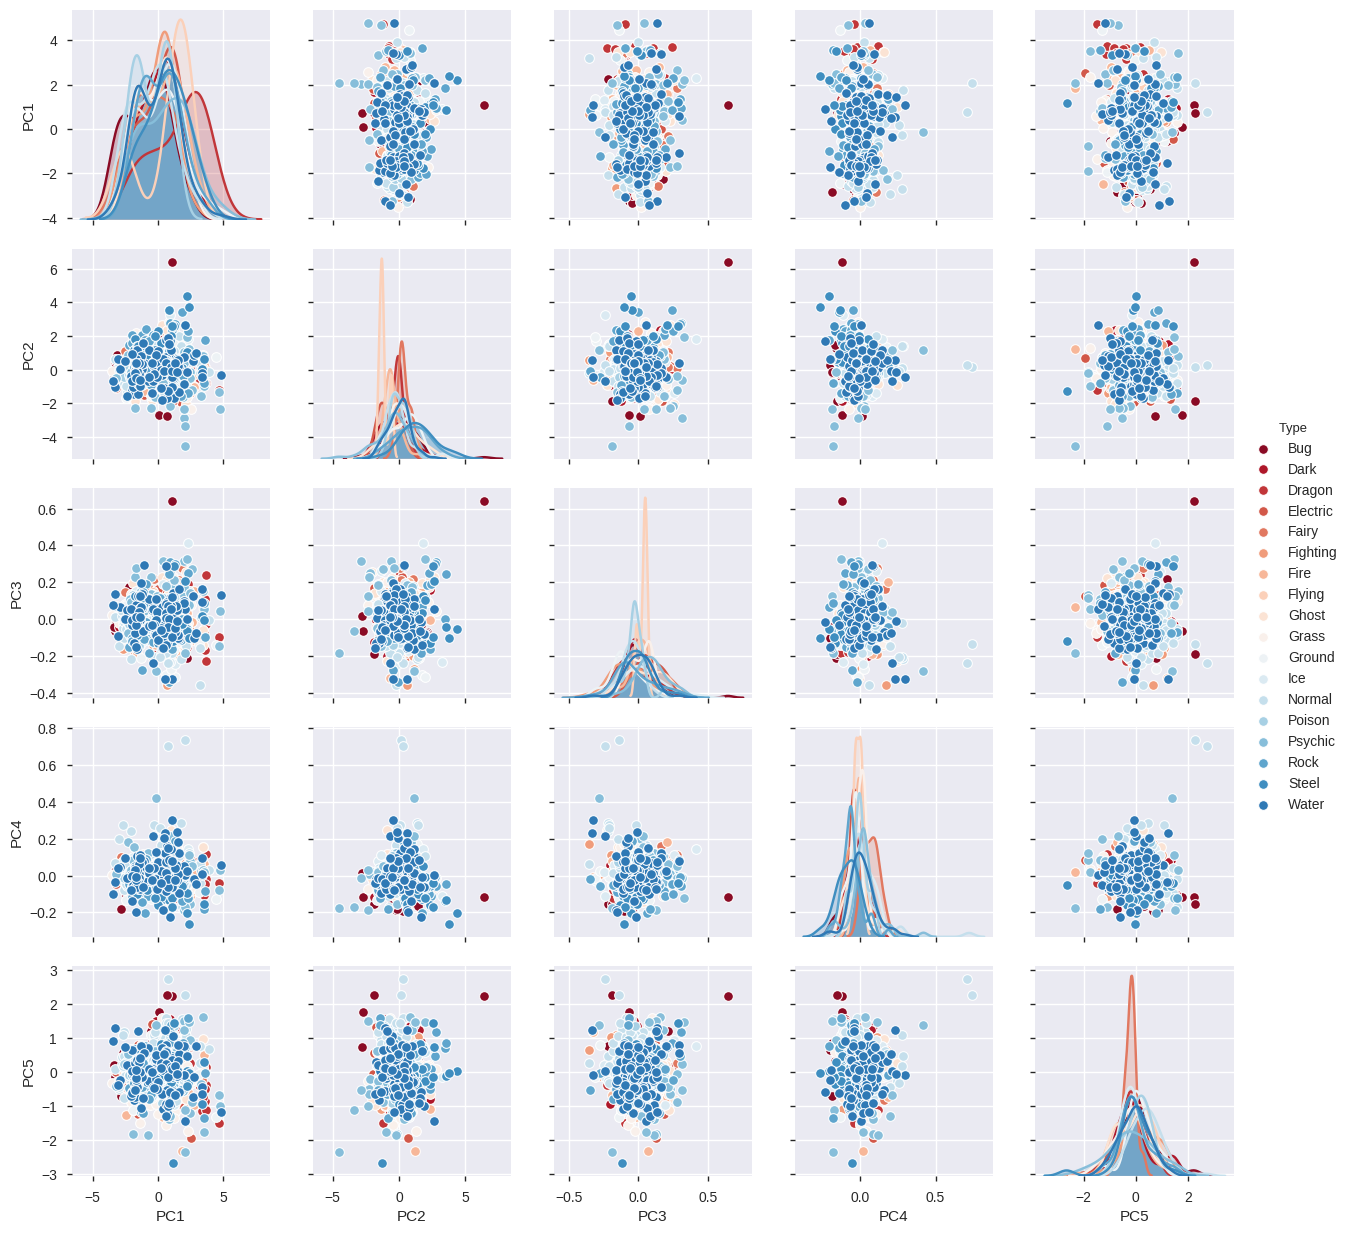

In [47]:
g = sns.pairplot(pc_types, hue='Type', palette=sns.color_palette("RdBu", n_colors=20))

In [0]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [0]:
#elbow method
x = []
y = []
for k in range (1, 11):
    # create a kmeans model on our data, using k clusters.  
    # random_state helps ensure that the algorithm returns the same results each time.
    ekmeans = KMeans(n_clusters=k, random_state=10).fit(pcscores.iloc[:, :])
    eklabels = ekmeans.labels_
    # sum of distances of samples to their closest cluster center
    interia = ekmeans.inertia_
    x.append(k)
    y.append(interia)

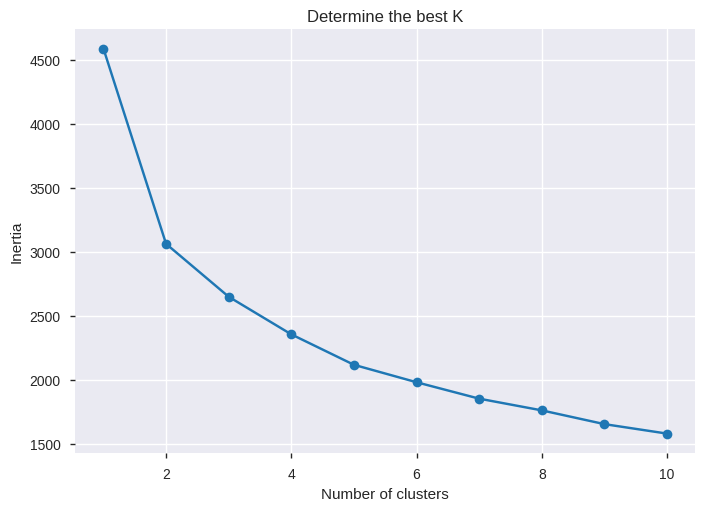

In [50]:
f, ax = plt.subplots()
ax.plot(x, y, zorder=2, marker='o')

#for i, txt in enumerate(y):
#    ax.annotate(int(txt), (x[i],y[i]))

plt.title("Determine the best K")    
ax.set_xlabel("Number of clusters")
ax.set_ylabel("Inertia")
plt.show()

In [51]:
cluster_num = 4
kmeans = KMeans(n_clusters=cluster_num, random_state=10)
kmeans.fit(pcscores)

centroids = kmeans.cluster_centers_
klabels = kmeans.labels_
#print(centroids)

gname = []
gcenters = []
for i in range(cluster_num):
    gname.append(i)
    center = centroids[i].tolist()
    (x, y) = (center[0], center[1])
    gcenters.append((x, y))
    groups = dict(zip(gname, gcenters))

for i in range(cluster_num):
    group = 'cluster'+str(i+1)
    print("Count of "+group+' :', str(klabels.tolist().count(i)))

Count of cluster1 : 280
Count of cluster2 : 119
Count of cluster3 : 205
Count of cluster4 : 196


In [0]:
pkmeans = data.copy()
pkmeans['klabel'] = klabels
KmeansPoke = pd.concat([pkmeans, pcscores], axis=1)

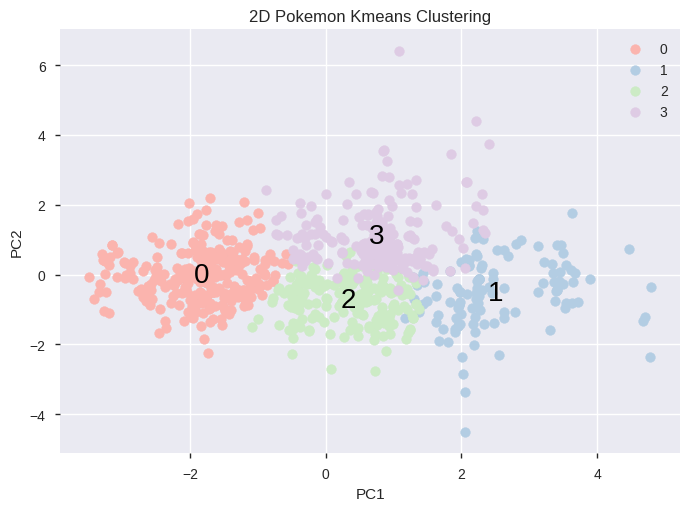

In [53]:
colors = plt.cm.Pastel1(np.linspace(0, 1, 10))
groups_keys = list(groups.keys())
#loop through labels and plot each cluster
for i, label in enumerate(groups.keys()):

    #add data points 
    plt.scatter(x=KmeansPoke.loc[KmeansPoke['klabel']==label, 'PC1'], 
                y=KmeansPoke.loc[KmeansPoke['klabel']==label,'PC2'],
                color=colors[i])
    
    #add label
    plt.annotate(label, xy = groups[groups_keys[i]],
                 horizontalalignment='center', verticalalignment='center',
                 size=20, color='k') 
    

plt.title('2D Pokemon Kmeans Clustering')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(groups_keys, loc='best')
plt.show()

In [60]:
kstats = KmeansPoke.pivot_table(values=stats,index=['klabel'], aggfunc='mean').fillna(0)
kstats = kstats.transpose()
kstats = kstats.assign(All=data[stats].mean())
kstats

klabel,0,1,2,3,All
Attack,53.678571,119.907563,84.400000,84.693878,79.00125
Defense,52.346429,92.260504,66.185366,101.377551,73.84250
HP,49.907143,89.638655,70.565854,83.163265,69.25875
Sp. Atk,47.628571,119.285714,77.839024,75.346939,72.82000
Sp. Def,49.110714,97.193277,71.624390,89.397959,71.90250
Speed,49.192857,100.134454,91.043902,52.387755,68.27750
Total,301.864286,618.420168,461.658537,486.367347,435.10250


In [61]:
data[stats].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Attack,800.0,79.00125,32.457366,5.0,55.00,75.0,100.0,190.0
Defense,800.0,73.84250,31.183501,5.0,50.00,70.0,90.0,230.0
HP,800.0,69.25875,25.534669,1.0,50.00,65.0,80.0,255.0
Sp. Atk,800.0,72.82000,32.722294,10.0,49.75,65.0,95.0,194.0
Sp. Def,800.0,71.90250,27.828916,20.0,50.00,70.0,90.0,230.0
Speed,800.0,68.27750,29.060474,5.0,45.00,65.0,90.0,180.0
Total,800.0,435.10250,119.963040,180.0,330.00,450.0,515.0,780.0


In [62]:
kpca = KmeansPoke.pivot_table(values=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'],index=['klabel'], aggfunc='mean').fillna(0)
kpca.transpose()

klabel,0,1,2,3
PC1,-1.829683,2.505731,0.332337,0.744899
PC2,-0.010223,-0.525328,-0.725396,1.092259
PC3,0.023359,-0.050505,-0.037303,0.036310
PC4,-0.008580,-0.134123,-0.139938,0.240053
PC5,-0.086957,-0.219663,0.264832,-0.019402


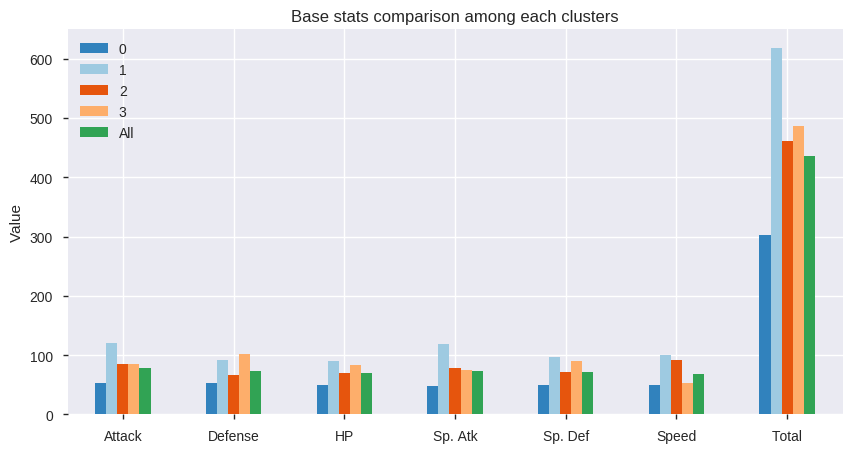

In [63]:
colors = plt.cm.tab20c(np.linspace(0, 1, 10))

ax1 = kstats.plot(kind='bar', color=colors, figsize=(10, 5))
ax1.set_ylabel("Value")
ax1.set_xticklabels(kstats.index,rotation='horizontal')
ax1.set_title("Base stats comparison among each clusters")
plt.legend(prop={'size':10})
plt.show()

In [64]:
ktype = KmeansPoke.pivot_table(values='Name', index=['Type 1'],columns=['klabel'], aggfunc='count').fillna(0).astype(int)
ktype2 = KmeansPoke.pivot_table(values='Name', index=['Type 2'],columns=['klabel'], aggfunc='count').fillna(0).astype(int)
ktype.transpose()

Type 1,Bug,Dark,Dragon,Electric,Fairy,Fighting,Fire,Flying,Ghost,Grass,Ground,Ice,Normal,Poison,Psychic,Rock,Steel,Water
klabel,,,,,,,,,,,,,,,,,,
0,30,10,5,12,8,9,13,1,12,25,13,8,42,14,18,14,6,40
1,4,5,19,7,1,1,13,2,4,6,4,3,9,0,17,6,6,12
2,23,10,5,16,0,9,21,1,8,18,5,6,31,9,13,6,1,23
3,12,6,3,9,8,8,5,0,8,21,10,7,16,5,9,18,14,37


In [65]:
ktype2.transpose()

Type 2,Bug,Dark,Dragon,Electric,Fairy,Fighting,Fire,Flying,Ghost,Grass,Ground,Ice,None,Normal,Poison,Psychic,Rock,Steel,Water
klabel,,,,,,,,,,,,,,,,,,,
0,2,5,4,2,9,2,4,27,5,11,9,2,159,2,15,8,4,4,6
1,0,5,9,1,3,13,5,21,2,1,4,3,38,0,2,8,0,3,1
2,0,8,3,1,5,8,2,37,2,3,6,2,99,2,13,8,0,4,2
3,1,2,2,2,6,3,1,12,5,10,16,7,90,0,4,9,10,11,5


In [0]:
mega = KmeansPoke['Name'].str.contains('Mega')    
KmeansPoke['Mega'] = mega

In [0]:
kleg = KmeansPoke.pivot_table(values='Name', index=['Legendary', 'Mega'],columns=['klabel'], aggfunc='count').fillna(0).astype(int)

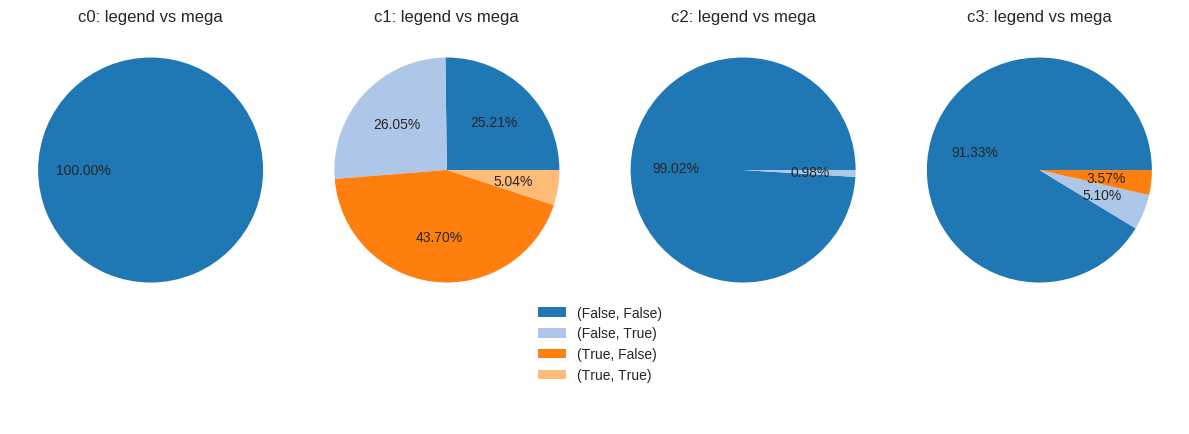

In [71]:
def my_autopct(pct):
    return ('%.2f%%' % pct) if pct > 0 else ''

colors = plt.cm.tab20(np.linspace(0, 1, 20))

    
fig, axes = plt.subplots(1, 4,  figsize=(12,6))
for ax in axes.flat:
    ax.axis('off')
    
for ax, col in zip(axes.flat, kleg.columns):
    data1 = kleg[col]  
    
    pie = ax.pie(data1, colors=colors, autopct=my_autopct)
    ax.set(ylabel='', title="c"+str(col)+": legend vs mega", aspect='equal')

fig.legend(pie[0], kleg.index, loc="center", bbox_to_anchor=(0.5,0.15))
plt.tight_layout()
plt.show()